# Квантизация больших языковых моделей в переопределённом базисе.

### Базовая статья: https://openreview.net/pdf?id=40rikZ1pCm

#### Гладков Андрей

In [68]:
import torch
import torch.linalg as LA
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import transformers
from sklearn.cluster import KMeans
import re
from tqdm import tqdm
from torch import nn
import copy
import warnings

from datasets import load_dataset
from transformers import AutoTokenizer, DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification
import numpy as np
from datasets import load_metric
from transformers import TrainingArguments, Trainer

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

MAX_ITER = 10000
N_CLUSTERS = 4

## Основной функционал

In [88]:
class Quantizer:
    def __init__(self, Q1='random', Q2='random', eps=1e-4):
        self.eps = eps
        self.Q1 = Q1
        self.Q2 = Q2
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.N_CLUSTERS = N_CLUSTERS
        
    def get_random_orthogonal(self, N, M, dtype=torch.float32, kind='normal'):
        if kind == 'normal':
            matrix = torch.randn(N, M).to(dtype).to(device)
            Q1, _ = LA.qr(matrix)
            matrix = torch.randn(M, N).to(dtype).to(device)
            Q2, _ = LA.qr(matrix)
            return Q1, Q2 
        
    def decompose_matrix(self, X_arg):
        X = X_arg.clone()
        dtype = X.dtype 
        U = torch.zeros_like(X).to(dtype).to(self.device)
        Vh = torch.zeros_like(X).to(dtype).to(self.device)
        Q1, Q2 = self.get_random_orthogonal(X.shape[0], X.shape[1], X.dtype)
        X0 = X.clone()
        proj = lambda X, Y: X.view(-1).T @ Y.view(-1) / torch.norm(Y) ** 2 * Y
        num_iter = 0 
        while (torch.norm(X0 - U - Vh) >= self.eps) and (num_iter < MAX_ITER):
            Y = Q1.T @ X @ Q2
            if torch.sum(torch.abs(X)) > torch.sum(torch.abs(Y)):
                pi = proj(X, torch.sign(X))
                U += pi
            else:
                pi = proj(X, Q1 @ torch.sign(Y) @ Q2.T)
                Vh += pi 
            X -= pi
            num_iter += 1
        
        if num_iter == MAX_ITER:
            print('Reached maximal number of iterations')
            return X, X, torch.zeros_like(X).to(dtype).to(self.device), Q1, Q2
        else:
            return U, Vh, Q1.T @ Vh @ Q2, Q1, Q2
    
    def quantize_UV(self, U, V):
        u = U.clone().flatten()
        v = V.clone().flatten()

        kmeans_u = KMeans(n_clusters=self.N_CLUSTERS, random_state=0, n_init="auto").fit(u.view(-1,1).cpu())
        kmeans_v = KMeans(n_clusters=self.N_CLUSTERS, random_state=0, n_init="auto").fit(v.view(-1,1).cpu())
        
        for cluster in np.unique(kmeans_u.labels_):
            inds = np.where(kmeans_u.labels_ == cluster)[0]
            mean = torch.mean(u[inds])
            u[inds] = mean
        for cluster in np.unique(kmeans_v.labels_):
            inds = np.where(kmeans_v.labels_ == cluster)[0]
            mean = torch.mean(v[inds])
            v[inds] = mean
        return u, v, torch.from_numpy(kmeans_u.labels_), torch.from_numpy(kmeans_v.labels_)
    
    def decompose_v(x, Q,):
        self.device = X.device
        x = x.double()
        x0 = x.clone()
        Q = Q.double()
        u = torch.zeros_like(x).to(device).double()
        v = torch.zeros_like(x).to(device).double()
        proj = lambda x, y: x.T @ y / (torch.norm(y) ** 2) * y

        while torch.norm(x0 - u - v) >= eps:
            if torch.sum(torch.abs(x)) > torch.sum(torch.abs(Q.T @ x)):
                pi = proj(x, torch.sign(x))
                u += pi
            else:
                pi = proj(x, Q @ torch.sign (Q.T @ x))
                v += pi
            x -= pi
        return u, v

In [89]:
def plot_UV(u, v, centroids=None, labels=None):
    if centroids is None:
        sns.scatterplot(x=u.flatten().cpu(), y=v.flatten().cpu()).set(xlabel='U entries', ylabel='V entries')
    elif labels is None:
        sns.scatterplot(x=u.flatten().cpu(), y=v.flatten().cpu(),label='entries').set(xlabel='U entries', ylabel='V entries', title='Scatterplot of U and V entries')
        U, V = centroids
        sns.scatterplot(x=U.flatten().cpu(), y=V.flatten().cpu(), color='red', label='centroids').set(xlabel='U', ylabel='V', title='Scatterplot of U and V entries')
    else:
        U, V = centroids
        lu, lv = labels
        labels_all = lu * len(torch.unique(lu)) + lv
        sns.scatterplot(x=u.flatten().cpu(), y=v.flatten().cpu(), hue=labels_all, legend=False, palette='Spectral').set(xlabel='U entries', ylabel='V entries', title='Scatterplot of U and V entries')
        sns.scatterplot(x=U.flatten().cpu(), y=V.flatten().cpu(), color='red').set(xlabel='U entries', ylabel='V entries')
        plt.show()
        

def plot_hist(X, U, V): 
    fig, ax = plt.subplots(1, 3, figsize=(10,6))

    sns.histplot(U.flatten().cpu(), discrete=False, ax=ax[0]).set(title='U')
    sns.histplot(V.flatten().cpu(), discrete=False, ax=ax[1]).set(title='V')
    sns.histplot(X.flatten().cpu(), discrete=False, ax=ax[2]).set(title='X')
    
    plt.show()
    
def compute_errs(X, U, Vh, u, vh):
    return float(torch.norm(X - U - Vh) / torch.norm(X)), float(torch.norm(X - u - vh) / torch.norm(X))

## Эксперименты

### Случайные матрицы

In [90]:
N1 = 500
N2 = 500

X = torch.randn(N1, N2).to(device)

In [91]:
quant = Quantizer()
#X = torch.tensor(model.distilbert.transformer.layer[4].attention.v_lin.weight).detach().clone()
U, Vh, V, Q1, Q2 = quant.decompose_matrix(X)
u, v, lu, lv = quant.quantize_UV(U, V)

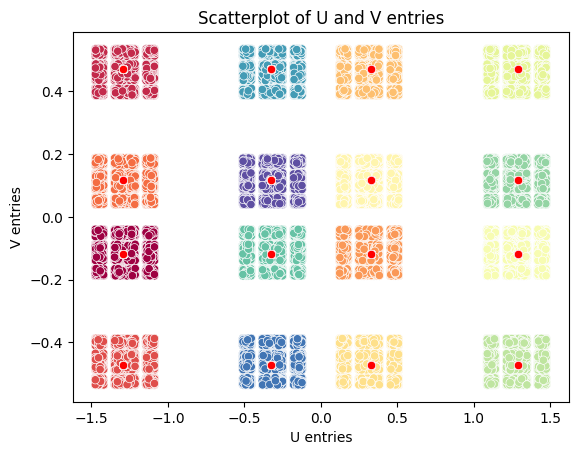

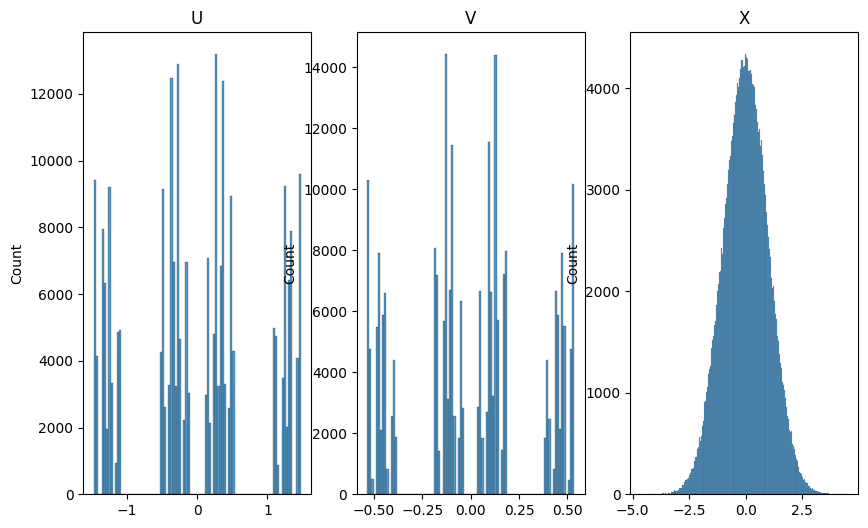

In [92]:
plot_UV(U, V, (u, v), (lu, lv))
plot_hist(X, U, V)

In [93]:
er1, er2 = compute_errs(X, U, Vh, u.reshape_as(Vh), Q1 @ v.reshape_as(Vh) @ Q2.T)
print(f'Относительная ошибка первичной аппроксимации: {er1:.2e}')
print(f'Относительная ошибка после квантизации: {er2:.2f}')

Относительная ошибка первичной аппроксимации: 1.52e-07
Относительная ошибка после квантизации: 0.13


### Линейные слои языковой модели

In [50]:
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

def compute_metrics(eval_pred):
    load_accuracy = load_metric("accuracy")
    load_f1 = load_metric("f1")
  
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = load_accuracy.compute(predictions=predictions, references=labels)["accuracy"]
    #f1 = load_f1.compute(predictions=predictions, references=labels)["f1"]
    return {"accuracy": accuracy}

def get_linear_layers(model):
    linear_names = []
    for name, layer in model.named_modules():
        if isinstance(layer, torch.nn.Linear):
            linear_names.append(re.sub(r'.(\d+).', r'.[\1].', str(name).replace('[', '.[')))
    return linear_names

In [66]:
imdb = load_dataset("imdb")
small_train_dataset = imdb["train"].shuffle(seed=42).select([i for i in list(range(10000))])
small_test_dataset = imdb["test"].shuffle(seed=42).select([i for i in list(range(2000))])

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
tokenized_train = small_train_dataset.map(preprocess_function, batched=True)
tokenized_test = small_test_dataset.map(preprocess_function, batched=True)


data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

Map: 100%|█████████████████████████| 2000/2000 [00:00<00:00, 2115.58 examples/s]
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.bias', 'pre_classifier.weight', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [67]:
repo_name = "model"
 
training_args = TrainingArguments(
   output_dir=repo_name,
   learning_rate=2e-5,
   per_device_train_batch_size=16,
   per_device_eval_batch_size=16,
   num_train_epochs=5,
   weight_decay=0.01,
   save_strategy="epoch",
)
 
trainer = Trainer(
   model=model,
   args=training_args,
   train_dataset=tokenized_train,
   eval_dataset=tokenized_test,
   tokenizer=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics,
)
#====================================

trainer.train()
model_quantized = copy.deepcopy(model)

#====================================

repo_name = "quantized_model"
 
training_args_quantized = TrainingArguments(
   output_dir=repo_name,
   learning_rate=2e-5,
   per_device_train_batch_size=16,
   per_device_eval_batch_size=16,
   num_train_epochs=5,
   weight_decay=0.01,
   save_strategy="epoch",
)
 
trainer_quantized = Trainer(
   model=model_quantized,
   args=training_args,
   train_dataset=tokenized_train,
   eval_dataset=tokenized_test,
   tokenizer=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics,
)

Detected kernel version 5.4.270, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss
500,0.341300
1000,0.195800
1500,0.135200
2000,0.091400
2500,0.052400
3000,0.027900


/beegfs/home/andrey.gladkov/environments/nlp/lib/python3.9/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None)
  warnings.warn(
Detected kernel version 5.4.270, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [69]:
err = []

quant = Quantizer()
linear_names = get_linear_layers(model_quantized)

failed = 0
for linear_name in tqdm(linear_names):
    obj = model_quantized
    for attr in linear_name.split('.'):
        if attr[0] != '[':
            obj = getattr(obj, attr)
        else:
            obj = obj.__getitem__(int(attr[1:-1]))
    with torch.no_grad():
        U, Vh, V, Q1, Q2 = quant.decompose_matrix(obj.weight)
        if np.isclose(torch.norm(V).cpu(), 0.0):
            failed += 1
            continue
        u, v, _, _ = quant.quantize_UV(U, V)
        N, M = obj.weight.shape
        u = u.view(N, M)
        vh = Q1 @ v.view(N, M) @ Q2.T
        
        err.append(float(torch.norm(torch.tensor(obj.weight - u - vh)) / torch.norm(torch.tensor(obj.weight))))
        obj.weight = nn.Parameter((u + vh).view(N, M))
        
print(f'Successful: {len(linear_names) - failed}/{len(linear_names)}, {(len(linear_names) - failed) / len(linear_names) * 100:.1f}%')

  0%|                                                    | 0/38 [00:00<?, ?it/s]/tmp/ipykernel_1631068/1925093323.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  err.append(float(torch.norm(torch.tensor(obj.weight - u - vh)) / torch.norm(torch.tensor(obj.weight))))
  3%|█▏                                          | 1/38 [00:00<00:11,  3.20it/s]/tmp/ipykernel_1631068/1925093323.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  err.append(float(torch.norm(torch.tensor(obj.weight - u - vh)) / torch.norm(torch.tensor(obj.weight))))
  5%|██▎                                         | 2/38 [00:00<00:10,  3.41it/s]/tmp/ipykernel_1631068/1925093323.py:24: UserWarning: To copy construct fr

Reached maximal number of iterations


 16%|██████▉                                     | 6/38 [00:22<03:22,  6.33s/it]

Reached maximal number of iterations


/tmp/ipykernel_1631068/1925093323.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  err.append(float(torch.norm(torch.tensor(obj.weight - u - vh)) / torch.norm(torch.tensor(obj.weight))))
 18%|████████                                    | 7/38 [00:22<02:14,  4.35s/it]/tmp/ipykernel_1631068/1925093323.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  err.append(float(torch.norm(torch.tensor(obj.weight - u - vh)) / torch.norm(torch.tensor(obj.weight))))
 21%|█████████▎                                  | 8/38 [00:22<01:31,  3.05s/it]/tmp/ipykernel_1631068/1925093323.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTen

Reached maximal number of iterations


 32%|█████████████▌                             | 12/38 [00:44<02:45,  6.37s/it]

Reached maximal number of iterations


/tmp/ipykernel_1631068/1925093323.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  err.append(float(torch.norm(torch.tensor(obj.weight - u - vh)) / torch.norm(torch.tensor(obj.weight))))
 34%|██████████████▋                            | 13/38 [00:44<01:53,  4.52s/it]/tmp/ipykernel_1631068/1925093323.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  err.append(float(torch.norm(torch.tensor(obj.weight - u - vh)) / torch.norm(torch.tensor(obj.weight))))
 37%|███████████████▊                           | 14/38 [00:45<01:17,  3.24s/it]/tmp/ipykernel_1631068/1925093323.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTen

Reached maximal number of iterations


 47%|████████████████████▎                      | 18/38 [01:06<02:07,  6.36s/it]

Reached maximal number of iterations


/tmp/ipykernel_1631068/1925093323.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  err.append(float(torch.norm(torch.tensor(obj.weight - u - vh)) / torch.norm(torch.tensor(obj.weight))))
 50%|█████████████████████▌                     | 19/38 [01:07<01:26,  4.54s/it]/tmp/ipykernel_1631068/1925093323.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  err.append(float(torch.norm(torch.tensor(obj.weight - u - vh)) / torch.norm(torch.tensor(obj.weight))))
 53%|██████████████████████▋                    | 20/38 [01:07<00:58,  3.28s/it]/tmp/ipykernel_1631068/1925093323.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTen

Reached maximal number of iterations


 63%|███████████████████████████▏               | 24/38 [01:29<01:29,  6.37s/it]

Reached maximal number of iterations


/tmp/ipykernel_1631068/1925093323.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  err.append(float(torch.norm(torch.tensor(obj.weight - u - vh)) / torch.norm(torch.tensor(obj.weight))))
 66%|████████████████████████████▎              | 25/38 [01:29<00:59,  4.54s/it]/tmp/ipykernel_1631068/1925093323.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  err.append(float(torch.norm(torch.tensor(obj.weight - u - vh)) / torch.norm(torch.tensor(obj.weight))))
 68%|█████████████████████████████▍             | 26/38 [01:29<00:39,  3.26s/it]/tmp/ipykernel_1631068/1925093323.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTen

Reached maximal number of iterations


 79%|█████████████████████████████████▉         | 30/38 [01:51<00:51,  6.38s/it]

Reached maximal number of iterations


/tmp/ipykernel_1631068/1925093323.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  err.append(float(torch.norm(torch.tensor(obj.weight - u - vh)) / torch.norm(torch.tensor(obj.weight))))
 82%|███████████████████████████████████        | 31/38 [01:52<00:33,  4.75s/it]/tmp/ipykernel_1631068/1925093323.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  err.append(float(torch.norm(torch.tensor(obj.weight - u - vh)) / torch.norm(torch.tensor(obj.weight))))
 84%|████████████████████████████████████▏      | 32/38 [01:52<00:20,  3.41s/it]/tmp/ipykernel_1631068/1925093323.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTen

Reached maximal number of iterations


 95%|████████████████████████████████████████▋  | 36/38 [02:14<00:12,  6.44s/it]

Reached maximal number of iterations


/tmp/ipykernel_1631068/1925093323.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  err.append(float(torch.norm(torch.tensor(obj.weight - u - vh)) / torch.norm(torch.tensor(obj.weight))))
100%|███████████████████████████████████████████| 38/38 [02:16<00:00,  3.58s/it]

Successful: 25/38, 65.8%


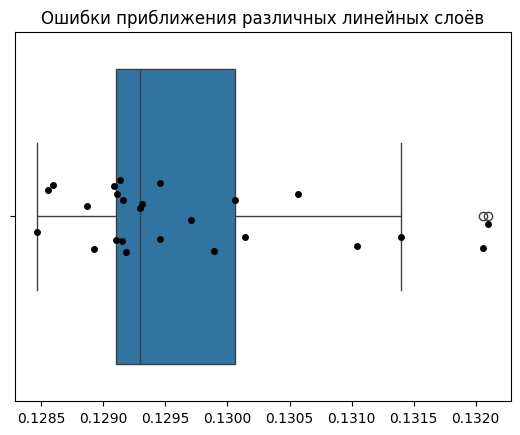

In [72]:
sns.boxplot(err, orient='h').set(title='Ошибки приближения различных линейных слоёв')
sns.stripplot(err, orient='h', color='black', legend=False)
plt.show()

In [74]:
from pprint import pprint
with warnings.catch_warnings():
    pprint('Результаты базовой модели')
    pprint(trainer.predict(tokenized_test)[2])
    pprint('Результаты квантизованной модели')
    pprint(trainer_quantized.predict(tokenized_test)[2])

'Результаты базовой модели'


{'test_accuracy': 0.928,
 'test_loss': 0.36931267380714417,
 'test_runtime': 13.2296,
 'test_samples_per_second': 151.176,
 'test_steps_per_second': 9.448}
'Результаты квантизованной модели'


{'test_accuracy': 0.9265,
 'test_loss': 0.3457612097263336,
 'test_runtime': 13.0262,
 'test_samples_per_second': 153.536,
 'test_steps_per_second': 9.596}


In [75]:
quant = Quantizer()
X = torch.tensor(model.distilbert.transformer.layer[4].attention.v_lin.weight).detach().clone()
U, Vh, V, Q1, Q2 = quant.decompose_matrix(X)
u, v, lu, lv = quant.quantize_UV(U, V)

/tmp/ipykernel_1631068/2847798855.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(model.distilbert.transformer.layer[4].attention.v_lin.weight).detach().clone()


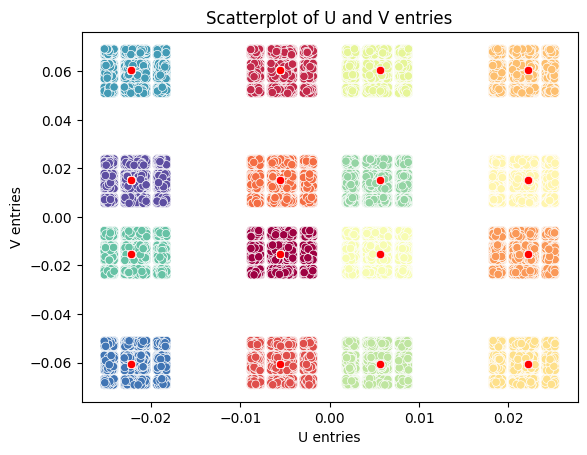

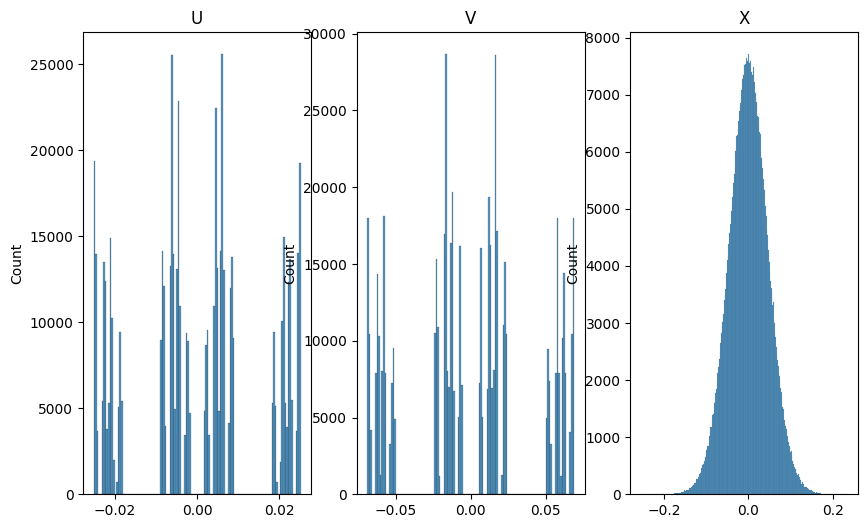

In [76]:
plot_UV(U, V, (u, v), (lu, lv))
plot_hist(X, U, V)

In [80]:
quant = Quantizer()
X = torch.tensor(model.distilbert.transformer.layer[0].ffn.lin1.weight).detach().clone()
U, Vh, V, Q1, Q2 = quant.decompose_matrix(X)
u, v, lu, lv = quant.quantize_UV(U, V)

/tmp/ipykernel_1631068/227878035.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(model.distilbert.transformer.layer[0].ffn.lin1.weight).detach().clone()


Reached maximal number of iterations


/beegfs/home/andrey.gladkov/environments/nlp/lib/python3.9/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


In [ ]:
plot_UV(U, V)
#plot_hist(X, U, V)

In [78]:
linear_names[4]

'distilbert.transformer.layer.[0].ffn.lin1'